# Цель Блокнота

Решение задачи регрессии в scikit-learn с помощью модели Случайный Лес
* Создание класса TargetEncoder для кодирования категориальных признаков
* Обучение класса `RandomForest`
* Сохранение модели

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler # Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder # Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder # Импортируем порядковое кодирование от scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный признак.

Среди указанных признаков приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди признак есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка в основном из [раннего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно

Также для числовых признаков убрано масштабирование (посколько деревья решений могут обходиться и без них без потери качества)

Вместо one-hot кодирования предлагается простая реализация `TargetEncoder`, которая заменяет категориальный признак на среднее значение целевой переменной по категории. Это позволяет "осознанно" использовать категории в деревьях решений без "разрастания" признаков до большого числа (как в случае применения one-hot кодирования)

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

Класс `TargetEncoder` принимает необязательный параметр `cols`, который представляет собой список столбцов для кодирования. Если `cols` не указан, он будет кодировать все категориальные столбцы во фрейме данных.

Метод `fit` вычисляет среднее целевое значение для каждого уникального значения в указанных столбцах. Затем он сохраняет средние целевые значения в словаре.

Метод `transform` использует средние целевые значения, хранящиеся в словаре, для замены категориальных значений их соответствующими средними целевыми значениями. Если категориальное значение не найдено в словаре, оно заменяется средним значением столбца.

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.target_mean = {}

    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.target_mean[col] = {}
            X_copy = X.copy()
            X_copy[y.name]=y
            self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            X[col] = X[col].map(self.target_mean[col])
            X[col] = X[col].fillna(np.mean(X[col]))
        return X

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', None)
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', None)
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('power', None)
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', TargetEncoder())

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', TargetEncoder())
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', TargetEncoder())
])

cat_model = ['Model']

preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

# Случайный Лес для Регрессии

In [ ]:
from sklearn.ensemble import RandomForestRegressor # Случайный Лес для Регрессии от scikit-learn

from sklearn.model_selection import train_test_split # функция разбиения на тренировочную и валидационную выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X, y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

## Сразу используем все признаки

**Преобразуем данные**

Поскольку мы используем TargetEncoder для обучения, необходимо использовать столбец целевой переменной

In [ ]:
# Сначала обучаем на тренировочных данных, при этом одновременно трансформируем их
X_train_prep = preprocessors_all.fit_transform(X_train, y_train)
# потом трансформируем на валидационных данных
X_val_prep = preprocessors_all.transform(X_val)

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                    cat_transmission,
                    cat_style_fuel,
                    cat_make,
                    cat_model])

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса
* "Обучаем" через метод `.fit`

In [ ]:
model_rf = RandomForestRegressor(n_estimators=150,
                                max_depth=10,
                            oob_score=True
                              )

model_rf.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=10, n_estimators=150, oob_score=True)

## Визуализация значимости признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

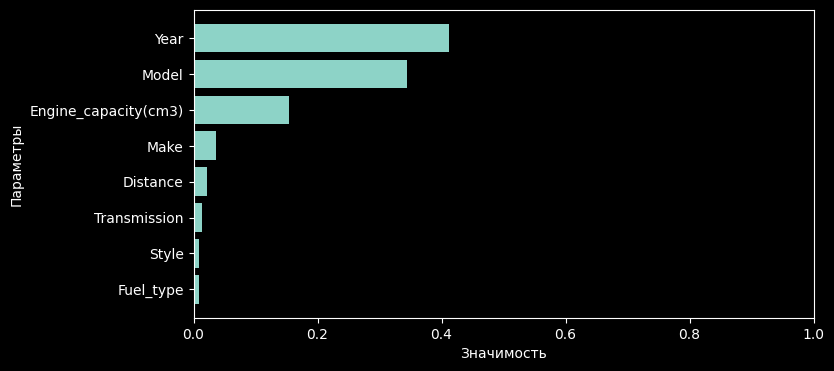

In [ ]:
feature_importance_plotter(model_rf, columns)

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_rf, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_rf, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_rf, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_rf, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9123
r2 на валидационной выборке: 0.8631
mse на тренировочной выборке: 5330938.4622
mse на валидационной выборке: 8617223.2719


Оценка случайного леса на out-of-bag данных

In [ ]:
model_rf.oob_score_

0.855318794230435

## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_rf,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,12.196941,0.045744,0.872427,-7.553815e+06,-1700.167257,-23049.291348
1,6.093210,0.045799,0.864313,-8.772997e+06,-1706.232142,-36534.191217
2,7.097974,0.045219,0.858663,-8.677001e+06,-1672.407164,-39611.307031
3,6.115705,0.044152,0.873570,-7.551052e+06,-1685.090601,-21708.153047
4,7.084121,0.043206,0.848860,-8.851472e+06,-1667.526978,-42734.113378




test_R2      8.635668e-01
test_-MSE   -8.281268e+06
test_-MAE   -1.686285e+03
test_-Max   -3.272741e+04
dtype: float64


## Визуализация ошибок от scikit-learn

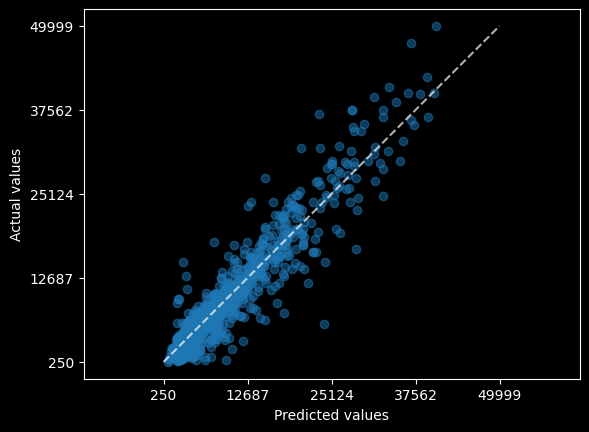

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_rf.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель случайного леса лучше всех справляется с предсказанием целевой переменной (метрика r2 на кросс-валидации `0.86` против `0.65` у линейной регрессии, `0.74` у ближайших соседей и `0.75` у простых деревьев решений)

* Значимость признаков в целом повторяет результаты на одиночных деревьях: год и модель так и остались самыми значимыми, подросла значимость объема двигателя, значимость остальных признаков гораздо ниже



## Поиск Лучших Гиперпараметров по Сетке Параметров

In [ ]:
from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров

from sklearn.metrics import make_scorer # функция для создания объекта из метрики для использования в кросс-валидации

In [ ]:
param_grid = {
    "n_estimators": np.arange(50,300,100),
    "max_depth": np.arange(10,40,10),
}

In [ ]:
scorer = make_scorer(r2_score)

In [ ]:
RF_GS = GridSearchCV(estimator = RandomForestRegressor(), # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                       cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 3 # чтобы он всё подробно расписал, если не интересно - пишем 0
                       )
RF_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([ 50, 150, 250])},
             scoring=make_scorer(r2_score), verbose=3)

Стандартное обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` все перечисленные комбинации гиперпараметров / аргументов из `param_grid`

In [ ]:
RF_GS.fit(X_train_prep, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.871 total time=   2.0s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.862 total time=   2.0s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.855 total time=   2.0s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.873 total time=   2.0s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.848 total time=   2.5s
[CV 1/5] END ....max_depth=10, n_estimators=150;, score=0.873 total time=   6.3s
[CV 2/5] END ....max_depth=10, n_estimators=150;, score=0.865 total time=   6.1s
[CV 3/5] END ....max_depth=10, n_estimators=150;, score=0.858 total time=   6.7s
[CV 4/5] END ....max_depth=10, n_estimators=150;, score=0.874 total time=   5.9s
[CV 5/5] END ....max_depth=10, n_estimators=150;, score=0.850 total time=   6.7s
[CV 1/5] END ....max_depth=10, n_estimators=250;, score=0.874 total time=  11.2s
[CV 2/5] END ....max_depth=10, n_estimators=250;,

Лучший Кандидат

In [ ]:
rf_best=RF_GS.best_estimator_
rf_best

RandomForestRegressor(max_depth=20, n_estimators=150)

In [ ]:
rf_best.fit(X_train_prep, y_train);

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(rf_best, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(rf_best, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(rf_best, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(rf_best, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9789
r2 на валидационной выборке: 0.8656
mse на тренировочной выборке: 1285283.3323
mse на валидационной выборке: 8460247.0557


### Проанализируем результат

На уровне гиперпараметров

In [ ]:
DF_rf = pd.DataFrame(RF_GS.cv_results_)
DF_rf.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [ ]:
DF_ = DF_rf[[ # берем только гиперпараметры,
       'param_n_estimators',
       'param_max_depth',
                 'mean_test_score', # среднее значение метрики на кросс-валидации
             'std_test_score', # разброс метрики на кросс-валидации
             'rank_test_score', # место
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
4,150,20,0.870738,0.009420,1
5,250,20,0.870030,0.009932,2
7,150,30,0.869481,0.009767,3
8,250,30,0.869252,0.009337,4
6,50,30,0.868599,0.008744,5
3,50,20,0.868068,0.008961,6
1,150,10,0.864194,0.009122,7
2,250,10,0.863784,0.009250,8
0,50,10,0.861666,0.009515,9


Небольшие выводы

* Увеличение числа деревьев в лесе и глубины леса даёт незначительный, но прирост (метрика r2 на кросс-валидации `0.87` против `0.86`)


# Про то как, Сохранять Модель

In [ ]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [ ]:
dump(model_rf, 'model_rf.joblib')  # чтобы сохранить объект
dump(rf_best, 'model_rf_best.joblib')  # чтобы сохранить объект

['model_rf_best.joblib']